In [1]:
import numpy as np
import time
import sys

from matplotlib import pyplot as plt

### Moment Expansion in EPT ###
In this notebook we demonstrate how to do the basic EPT calculations. Let's start with the moment expansion.

An important difference between the EPT and LPT calculations is that the former requires us to input a "no-wiggle" version of the linear power spectrum, plotted below. This is included in the class as a keyword pnw, which if set to none defaults to a Savitsky-Golay filtered input linear power spectrum. However, we have found that the wiggle/no-wiggle split is cleaner if you first divide out the Eisenstein and Hu ansatz, which we leave to the user as it is cosmology dependent.


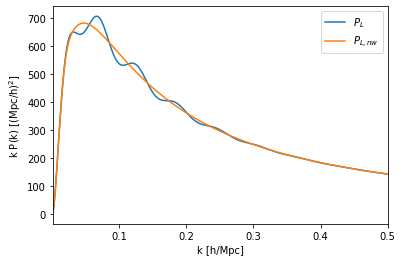

In [2]:
# Run the basic EPT class:
from velocileptors.EPT.moment_expansion_fftw import MomentExpansion

# we scale the z = 0 power spectrum given to give z = 0.8 results
z, D, f = 0.8, 0.6819, 0.8076
k, p = np.loadtxt('pk.dat').T
knw, pnw = np.loadtxt('pnw.dat').T

plt.plot(k, k*p, label=r'$P_L$')
plt.plot(k, k*pnw, label=r'$P_{L,nw}$')
plt.legend()
plt.xlim(1e-3, 0.5)
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'k P(k) [(Mpc/h)$^2$]')
plt.show()


The EPT calculation is very fast and does not depend on the number of points nk evaluated, here set to nk = 100.

In [3]:
start = time.time()
mome = MomentExpansion(k, D**2*p, pnw=D**2*pnw, kmin = 5e-3, kmax = 0.25, nk = 100,\
                       beyond_gauss=True, one_loop= True, third_order = True,\
                       N = 2000, extrap_min=-6, extrap_max=2, cutoff = 100, threads=1)
end = time.time()
print(end-start)

1.2723963260650635


In [4]:
# We can use this to compute the various velocity moments in EPT

In [5]:
# Default parameters for the halo plots in Chen, Vlah and White (2020)
sn, sv, s0 = 1380, 3800,  7122
b1, b2, bs, b3 = 1.68593608, -1.17, -0.715, -0.479
alpha, alphav, alpha0, alpha2 = 16.9, -10.8, 21.0, 5.40

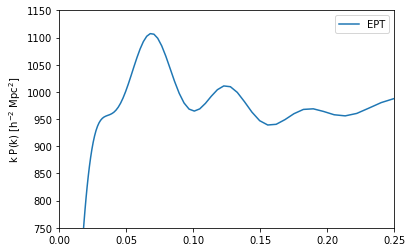

In [6]:
pth = mome.combine_bias_terms_pk(b1,b2,bs,b3,alpha,sn) #pept_func(kdat, sn, b1, b2, bs, b3, alpha )
plt.plot( mome.kv, mome.kv * pth,label=r'EPT' )

#plt.plot(ept.ept.kint, ept.ept.kint* (b1**2 * ept.ept.pint + sn) )
plt.legend()

plt.xlim(0,0.25)
plt.ylim(750,1150)

plt.ylabel(r'k P(k) [h$^{-2}$ Mpc$^2$]')
plt.show()

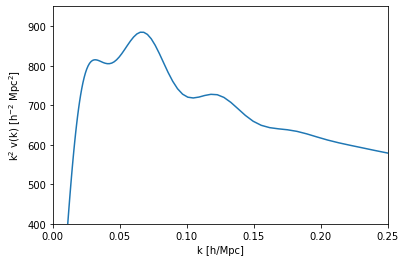

In [7]:
vth = mome.combine_bias_terms_vk(b1,b2,bs,b3,alphav,sv)
plt.plot(mome.kv, -f * mome.kv**2 * vth)


plt.ylabel(r'k$^2$ v(k) [h$^{-2}$ Mpc$^2$]')
plt.xlim(0,0.25)
plt.ylim(400,950)
plt.xlabel('k [h/Mpc]')
plt.show()

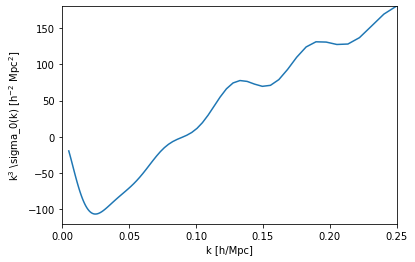

In [8]:
s0th, s2th = mome.combine_bias_terms_sk(b1,b2,bs,b3,alpha0,alpha2,s0)
plt.plot(mome.kv, f**2 * mome.kv**3 * s0th)

plt.ylabel(r'k$^3$ \sigma_0(k) [h$^{-2}$ Mpc$^2$]')
plt.xlim(0,0.25)
plt.ylim(-120,180)
plt.xlabel('k [h/Mpc]')
plt.show()

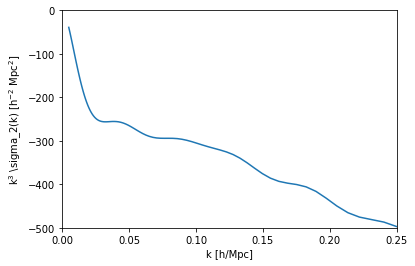

In [9]:
plt.plot(mome.kv, f**2 * mome.kv**3 * s2th)

plt.ylabel(r'k$^3$ \sigma_2(k) [h$^{-2}$ Mpc$^2$]')
plt.xlim(0,0.25)
plt.ylim(-500,0)
plt.xlabel('k [h/Mpc]')
plt.show()

In [10]:
# and combine them into the power spectrum:

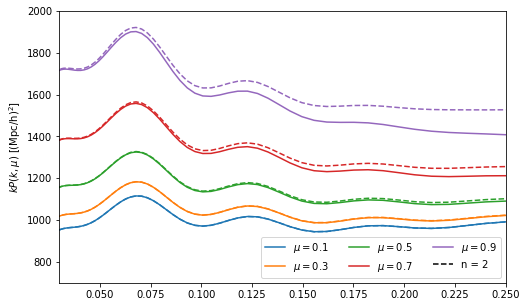

In [11]:
# Now combine into wedges via the moment expansion
plt.figure(figsize=(8,5))

mus = [0.1, 0.3, 0.5, 0.7, 0.9]

for ii, mu in enumerate(mus):
    
    # The c3 parameter is the counterterm ansatz to the third moment
    # Note that c3 enters as c3 / 6 * k^2 mu^4 P(k)
    
    pars = [b1,b2,bs,b3,alpha,alphav,alpha0,alpha2,sn,sv,s0]
    
    kw, pw = mome.compute_redshift_space_power_at_mu(pars,f,mu, counterterm_c3 = -6*10/D**2, beyond_gauss=False,reduced=False)
    plt.plot(kw, kw*pw,'C'+str(ii)+'-',label=r'$\mu = %.1f$'%(mu))
    
    kkw, pw = mome.compute_redshift_space_power_at_mu(pars,f,mu, counterterm_c3 = 0, beyond_gauss=False,reduced=False)
    plt.plot(kw, kw*pw,'C'+str(ii)+'--')

plt.plot(kw, -1000*kw, 'k--', label='n = 2')    
    
plt.ylabel(r'$k P(k,\mu)$ [(Mpc/h)$^2$]')


plt.xlim(0,0.25)
plt.ylim(500,2000)

plt.legend(ncol=3,loc='lower right')

plt.xlim(0.03,0.25)
plt.ylim(700,2000)



plt.show()

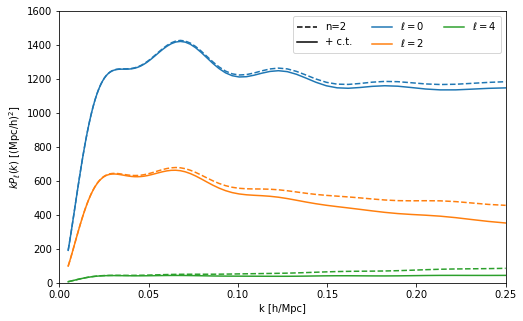

In [12]:
# ... and multipoles
plt.figure(figsize=(8,5))

ks, p0g, p2g, p4g = mome.compute_redshift_space_power_multipoles(pars,f,counterterm_c3=0)
ks, p0, p2, p4 = mome.compute_redshift_space_power_multipoles(pars,f,counterterm_c3=-6*10/D**2)

plt.plot(ks, -1000*ks,'k--',label='n=2')
plt.plot(ks, -1000*ks,'k-',label='+ c.t.')


plt.plot(ks, ks*p0,'C0-',label=r'$\ell = 0$')
plt.plot(ks, ks*p0g,'C0--')

plt.plot(ks, ks*p2,'C1-',label=r'$\ell = 2$')
plt.plot(ks, ks*p2g,'C1--')

plt.plot(ks, ks*p4,'C2-',label=r'$\ell = 4$')
plt.plot(ks, ks*p4g,'C2--')

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$k P_\ell(k)$ [(Mpc/h)$^2$]')

plt.xlim(0,0.25)
plt.ylim(0,1600)

plt.legend(ncol=3,loc='upper right')

plt.show()

### Direct Evaluationa of One-Loop Redshift-Space Power Spectrum ###
We can also take an extra step and resum contributions from bulk velocities. This gives the "full IR-resummed" power spectrum in EPT, whereas summing up real-space moments naturally only resums the displacements.

In [13]:
# Can also use compute the 1-loop P(k,mu) directly:
# note third_order is not a keyword in this class since it is always on
from velocileptors.EPT.ept_fullresum_fftw import REPT

In [14]:
start = time.time()
ept = REPT(k, D**2*p, pnw=D**2*pnw, kmin = 5e-3, kmax = 0.25, nk = 100,\
           beyond_gauss=True, one_loop= True,\
           N = 2000, extrap_min=-6, extrap_max=2, cutoff = 100, threads=1)

end = time.time()
print(end-start)

0.5668911933898926


In [15]:
# Compare with moment expansion:
b1, b2, bs, b3 = 1.68593608, -1.17, -0.715, -0.479
sn, sn2, sn4 = 0, 0, 0
alpha0, alpha2, alpha4, alpha6 = 0,0,0,0
pars = [b1, b2, bs, b3, alpha0, alpha2, alpha4, alpha6, sn, sn2, sn4]

Let's see how it compares to the moment expansion. The differences in the wiggles are most noticeable in the highest mu in, as one might expect. Note that there is a large contribution from one-loop wiggles.

Here we set beyond_gauss = True so that the third and fourth moments are included, since they are necessarily present in the direct one-loop calculation.

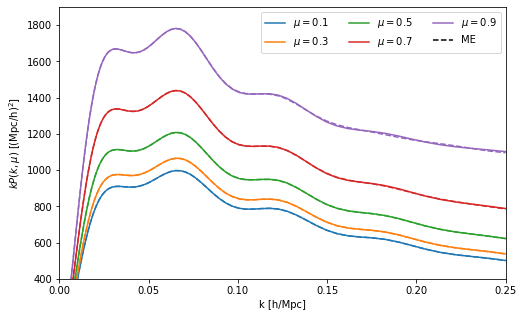

In [16]:
plt.figure(figsize=(8,5))

mus = [0.1, 0.3, 0.5, 0.7, 0.9]


for ii, mu in enumerate(mus):
    
    kw, pw = ept.compute_redshift_space_power_at_mu(pars,f,mu)
    plt.plot(kw, kw*pw,'C'+str(ii)+'-',label=r'$\mu = %.1f$'%(mu))
    
    kw, pw = mome.compute_redshift_space_power_at_mu(pars,f,mu,beyond_gauss=True)
    plt.plot(kw, kw*pw,'C'+str(ii)+'--')



plt.plot(kw, -1000*kw, 'k--',label='ME')
plt.ylabel(r'$k P(k,\mu)$ [(Mpc/h)$^2$]')
plt.xlabel(r'k [h/Mpc]')


plt.xlim(0,0.25)
plt.ylim(400,1900)

plt.legend(ncol=3,loc='upper right')



plt.show()

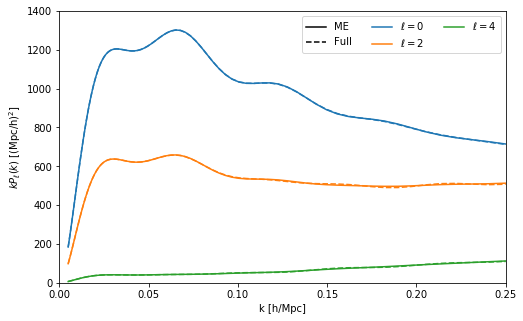

In [17]:
# ... and multipoles
plt.figure(figsize=(8,5))

ks, p0g, p2g, p4g = mome.compute_redshift_space_power_multipoles(pars,f,beyond_gauss=True,reduced=True)
ks, p0, p2, p4 = ept.compute_redshift_space_power_multipoles(pars,f)


plt.plot(ks, -1000*ks,'k-',label='ME')
plt.plot(ks, -1000*ks,'k--',label='Full')


plt.plot(ks, ks*p0,'C0-',label=r'$\ell = 0$')
plt.plot(ks, ks*p0g,'C0--')

plt.plot(ks, ks*p2,'C1-',label=r'$\ell = 2$')
plt.plot(ks, ks*p2g,'C1--')

plt.plot(ks, ks*p4,'C2-',label=r'$\ell = 4$')
plt.plot(ks, ks*p4g,'C2--')

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$k P_\ell(k)$ [(Mpc/h)$^2$]')

plt.xlim(0,0.25)
plt.ylim(0,1400)

plt.legend(ncol=3,loc='upper right')

plt.show()